In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import os
import csv
import wrangle_zillow
import prepare
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

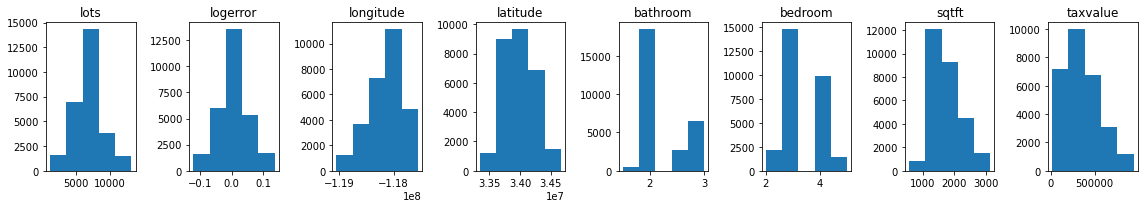

In [2]:
# load zillow data
zillow_train,zillow_validate,zillow_test=wrangle_zillow.wrangle_zillow(1.5)

In [3]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15782 entries, 40527 to 9701
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lots       15782 non-null  float64
 1   logerror   15782 non-null  float64
 2   longitude  15782 non-null  float64
 3   latitude   15782 non-null  float64
 4   bathroom   15782 non-null  float64
 5   bedroom    15782 non-null  float64
 6   fips       15782 non-null  object 
 7   sqtft      15782 non-null  float64
 8   zipcode    15782 non-null  object 
 9   taxvalue   15782 non-null  float64
 10  county     15782 non-null  object 
 11  month      15782 non-null  int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 1.6+ MB


In [4]:
zillow_train.describe().T

,count,mean,std,min,25%,50%,75%,max
lots,15782.0,6.849952e+03,2063.409831,1.276000e+03,5.633250e+03,6.645000e+03,7.840000e+03,1.306800e+04
logerror,15782.0,6.038086e-03,0.046522,-1.201488e-01,-2.145089e-02,5.935419e-03,3.265249e-02,1.349344e-01
longitude,15782.0,-1.181455e+08,308724.792487,-1.190442e+08,-1.183721e+08,-1.180902e+08,-1.179152e+08,-1.175597e+08
latitude,15782.0,3.398485e+07,241352.799773,3.334105e+07,3.381055e+07,3.396623e+07,3.416695e+07,3.466437e+07
bathroom,15782.0,2.265429e+00,0.432110,1.500000e+00,2.000000e+00,2.000000e+00,2.500000e+00,3.000000e+00
bedroom,15782.0,3.368458e+00,0.696448,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
sqtft,15782.0,1.732637e+03,463.870688,5.760000e+02,1.375000e+03,1.643000e+03,2.024000e+03,3.136000e+03
taxvalue,15782.0,3.467046e+05,200729.318489,1.921100e+04,1.943368e+05,3.210165e+05,4.700000e+05,9.443240e+05
month,15782.0,5.091370e+00,2.294356,1.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00,9.000000e+00


In [5]:
# the target will be taxamount

In [6]:
x_train, y_train = zillow_train.select_dtypes('float').drop(columns='taxvalue'),zillow_train.taxvalue
x_validate, y_validate = zillow_validate.select_dtypes('float').drop(columns='taxvalue'),zillow_validate.taxvalue
x_test, y_test = zillow_test.select_dtypes('float').drop(columns='taxvalue'),zillow_test.taxvalue

In [7]:
scaler=MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
x_validate_scaled = pd.DataFrame(scaler.fit_transform(x_validate), index=x_validate.index, columns=x_validate.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), index=x_test.index, columns=x_test.columns)

In [33]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# predict mean
y_train['baseline'] = y_train['taxvalue'].mean()
y_validate['baseline'] = y_validate['taxvalue'].mean()

# predict median
y_train['taxvalue_med'] = y_train['taxvalue'].median()
y_validate['taxvalue_med'] = y_validate['taxvalue'].median()

# RMSE of mean
rmse_train = mean_squared_error(y_train.taxvalue, y_train.baseline)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.baseline)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# RMSE of median
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_med)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_med)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))



RMSE using Mean
Train/In-Sample:  200722.96 
Validate/Out-of-Sample:  206045.64
RMSE using Median
Train/In-Sample:  202360.04 
Validate/Out-of-Sample:  207827.24


In [9]:
models = pd.DataFrame(
[
    {
        'model': 'baseline',
        'rmse': mean_squared_error(y_train['taxvalue'], y_train.baseline,squared=False),
        'r^2': explained_variance_score(y_train['taxvalue'], y_train.baseline)
    
    }
])
models

,model,rmse,r^2
0,baseline,200722.958949,0.0


In [10]:
def modeling(model, 
                  x_train, 
                  y_train, 
                  x_validate, 
                  y_validate, 
                  scores=models):
    model.fit(x_train, y_train.taxvalue)
    in_sample_pred = model.predict(x_train)
    out_sample_pred = model.predict(x_validate)
    model_name = input('model name?')
    y_train[model_name] = in_sample_pred
    y_validate[model_name] = out_sample_pred
    print(y_validate.shape)
    print(out_sample_pred.shape)
    rmse_val = mean_squared_error(
    y_validate.taxvalue, out_sample_pred, squared=False)
    r_squared_val = explained_variance_score(
        y_validate.taxvalue, out_sample_pred)
    return models.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    
    }, ignore_index=True)

In [11]:
models = modeling(LinearRegression(normalize=True), 
                  x_train_scaled, 
                  y_train, 
                  x_validate_scaled, 
                  y_validate, 
                  scores=models)

model name?OLS
(6764, 4)
(6764,)


In [12]:
models = modeling(LassoLars(alpha=1.0), 
                  x_train_scaled, 
                  y_train, 
                  x_validate_scaled, 
                  y_validate, 
                  scores=models)

model name?LARS
(6764, 5)
(6764,)


In [13]:
polyfeats = PolynomialFeatures(degree=2)
x_train_quad = polyfeats.fit_transform(x_train_scaled)
x_val_quad = polyfeats.transform(x_validate_scaled)
models = modeling(LinearRegression(), 
                  x_train_quad, 
                  y_train, 
                  x_val_quad, 
                  y_validate, 
                  scores=models)

model name?POLY
(6764, 6)
(6764,)


In [14]:
models = modeling(TweedieRegressor(power=1, alpha=0), 
                  x_train_scaled, 
                  y_train, 
                  x_validate_scaled, 
                  y_validate, 
                  scores=models)

model name?TWE
(6764, 7)
(6764,)


In [15]:
models

,model,rmse,r^2
0,baseline,200722.958949,0.000000
1,OLS,188468.243128,0.166794
2,LARS,188462.056447,0.166845
3,POLY,186964.066075,0.179920
4,TWE,188435.276773,0.166448


In [16]:
kbest = SelectKBest(f_regression, k=3)
kbest.fit(x_train_scaled, y_train.taxvalue)
mask = x_train_scaled.columns[kbest.get_support()].to_list()

In [17]:
models = modeling(LinearRegression(), 
                  x_train_scaled[mask], 
                  y_train, 
                  x_validate_scaled[mask], 
                  y_validate, 
                  scores=models)

model name?KBEST
(6764, 8)
(6764,)


In [18]:
models

,model,rmse,r^2
0,baseline,200722.958949,0.000000
1,OLS,188468.243128,0.166794
2,LARS,188462.056447,0.166845
3,POLY,186964.066075,0.179920
4,TWE,188435.276773,0.166448
5,KBEST,190032.454992,0.152617


In [19]:
models.rmse.min()

186964.0660746353

In [20]:
models['r^2'].max()

0.17992015505560377

In [21]:
polyfeats = PolynomialFeatures(degree=2)
x_test_quad = polyfeats.fit_transform(x_test_scaled)

In [22]:
def modeling(model, 
                  x_test, 
                  y_test, 
                  scores=models):
    model.fit(x_test, y_test)
    in_sample_pred = model.predict(x_test)
    model_name = input('model_name?')
    y_test[model_name] = in_sample_pred
    rmse_val = mean_squared_error(
    y_test, in_sample_pred, squared=False)**(1/2)
    r_squared_val = explained_variance_score(
        y_test, in_sample_pred)
    return models.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    
    }, ignore_index=True)

In [23]:
x_test_scaled=x_test_scaled.dropna()
x_test_scaled

,lots,logerror,longitude,latitude,bathroom,bedroom,sqtft
5778,0.390350,0.504666,0.673027,0.568190,0.333333,0.333333,0.286889
40570,0.448898,0.937954,0.080833,0.652870,0.333333,0.333333,0.581176
36995,0.565399,0.628260,0.628760,0.356114,0.333333,1.000000,0.570489
21548,0.312739,0.382590,0.908904,0.230114,0.333333,0.333333,0.405261
39419,0.400051,0.535269,0.664202,0.568671,0.333333,0.333333,0.345253
...,...,...,...,...,...,...,...
21580,0.374862,0.216391,0.953373,0.256370,1.000000,0.333333,0.448007
13748,0.671177,0.256060,0.603787,0.453050,0.333333,0.333333,0.309905
32262,0.571015,0.344082,0.733546,0.423409,1.000000,0.666667,0.834361
430,0.454089,0.351071,0.345867,0.648063,0.333333,0.666667,0.293465


In [24]:
y_test

5778     568539.0
40570    547080.0
36995    621319.0
21548    214299.0
39419    575646.0
           ...   
21580    456247.0
13748    506000.0
32262    644944.0
430      370202.0
46903    436766.0
Name: taxvalue, Length: 5637, dtype: float64

In [29]:
polyfeats = PolynomialFeatures(degree=2)
modeltest=LinearRegression()
modeltest.fit(x_test, y_test)
x_test = polyfeats.fit_transform(x_test_scaled)

In [30]:
rmse_val = mean_squared_error(
    y_test, modeltest.predict(x_test), squared=False)
r_squared_val = explained_variance_score(
        y_test, modeltest.predict(x_test))

In [31]:
rmse_val,r_squared_val

(184293.28939615286, 0.19025490881871654)